30000


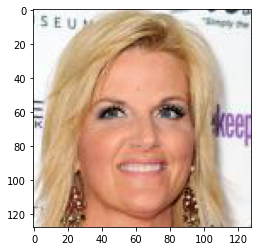

10000


In [1]:
#Create a folder called celeba in home dir where reconstructed images will be stored
#Considered only 100000 images for training

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as utils
import gc
import pywt
import IPython
import random
from random import sample
with __import__('importnb').Notebook():
        from wtvae_wt128 import CelebaDataset, VAE, Flatten

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
CUDA = True
BATCH_SIZE = 32
LOG_INTERVAL = 5
h_img = 128
w_img = 128
flat = h_img*w_img*3
train_losses = []

In [2]:
# w=pywt.Wavelet('bior2.2')


# dec_hi = torch.Tensor(w.dec_hi[::-1]).cuda() 
# dec_lo = torch.Tensor(w.dec_lo[::-1]).cuda()
# rec_hi = torch.Tensor(w.rec_hi).cuda()
# rec_lo = torch.Tensor(w.rec_lo).cuda()

# inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
#                            rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
#                            rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
#                            rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)

# def iwt(vres, levels=1):
#     h = vres.size(2)
#     w = vres.size(3)
#     res = vres.contiguous().view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
#     print(res.shape)
#     if levels>1:
#         res[:,:1] = iwt(res[:,:1], levels=levels-1)
#     res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
#     res = res[:,:,2:-2,2:-2] #removing padding
# #     print(res.shape)
#     return res

def truncated_normal_(tensor, mean=0, std=0.02):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        with torch.no_grad():
            truncated_normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [3]:
class LearnIWT(nn.Module):
    def __init__(self, image_channels=3, z_dim=100, device=None):
        super(LearnIWT, self).__init__()
        
        if device is None:
            self.cuda = False
            self.device = None
        else:
            self.device = device
            self.cuda = True
        
        self.z_dim = z_dim
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # X - Y Residual Encoder
        self.e1 = nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 64, 64, 64]
        weights_init(self.e1)
        self.instance_norm_e1 = nn.InstanceNorm2d(num_features=64, affine=False)

        self.e2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 128, 32, 32]
        weights_init(self.e2)
        self.instance_norm_e2 = nn.InstanceNorm2d(num_features=128, affine=False)

        self.e3 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 256, 16, 16]
        weights_init(self.e3)
        self.instance_norm_e3 = nn.InstanceNorm2d(num_features=256, affine=False)

        self.e4 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 512, 8, 8]
        weights_init(self.e4)
        self.instance_norm_e4 = nn.InstanceNorm2d(num_features=512, affine=False)
        
#         self.e5 = nn.Conv2d(512, 512, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 512, 4, 4]
#         weights_init(self.e5)
#         self.instance_norm_e5 = nn.InstanceNorm2d(num_features=512, affine=False)
        
        self.fc_enc = nn.Linear(512 * 8 * 8, 256)
        weights_init(self.fc_enc)
        
        self.fc_mean = nn.Linear(256, z_dim)
        weights_init(self.fc_mean)
        
        self.fc_var = nn.Linear(256, z_dim)
        weights_init(self.fc_var)
        
        # IWT Decoder        
        self.d1 = nn.Linear(3 * 128 * 128, 3 * 128 * 128)
        weights_init(self.d1)
        self.mu1 = nn.Linear(z_dim, 3 * 128 * 128)
        self.var1 = nn.Linear(z_dim, 3 * 128 * 128)
        self.instance_norm_d1 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt1 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
#         self.d2 = nn.Linear(3 * 128 * 128, 3 * 128 * 128)
#         weights_init(self.d2)
        self.mu2 = nn.Linear(z_dim, 3 * 128 * 128)
        self.var2 = nn.Linear(z_dim, 3 * 128 * 128)
        self.instance_norm_d2 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt2 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
    
    def encode(self, x, y):
        h = self.leakyrelu(self.instance_norm_e1(self.e1(x-y)))   #[b, 64, 64, 64]
        h = self.leakyrelu(self.instance_norm_e2(self.e2(h)))     #[b, 128, 32, 32]
        h = self.leakyrelu(self.instance_norm_e3(self.e3(h)))     #[b, 256, 16, 16]
        h = self.leakyrelu(self.instance_norm_e4(self.e4(h)))     #[b, 512, 8, 8]
#         h = self.leakyrelu(self.instance_norm_e5(self.e5(h)))     #[b, 512, 4, 4]
        h = self.leakyrelu(self.fc_enc(h.view(-1,512*8*8)))       #[b, 512 * 4 * 4]
        
        return self.fc_mean(h), F.softplus(self.fc_var(h))        #[b, z_dim]

    def reparameterize(self, mu, var):
        std = torch.sqrt(var)
        if self.cuda:
            eps = torch.FloatTensor(std.size()).normal_().to(self.device)
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu) 
    
    def decode(self, y, z):
        mu = self.mu1(z).reshape(-1, 3, 128, 128)
        var = self.var1(z).reshape(-1, 3, 128, 128)
        h = self.leakyrelu(var*self.instance_norm_d1(self.d1(y.view(y.shape[0], -1)).reshape(-1, 3, 128, 128)) + mu) #[b, 3, 128, 128]
        h = self.leakyrelu(self.iwt1(h))                               #[b, 3, 128, 128]
        
        mu = self.mu2(z).reshape(-1, 3, 128, 128)
        var = self.var2(z).reshape(-1, 3, 128, 128)
        h = self.leakyrelu(var*self.instance_norm_d2(self.d1(h.view(h.shape[0], -1)).reshape(-1, 3, 128, 128)) + mu) #[b, 3, 128, 128]
        h = self.leakyrelu(self.iwt2(h))                               #[b, 3, 128, 128]
        
        return self.sigmoid(h)
        
        
    def forward(self, x, y):
        mu, var = self.encode(x, y)
        if self.training:
            z = self.reparameterize(mu, var)
        else:
            z = mu
        x_hat = self.decode(y, z)
        
        return x_hat, mu, var
        
        
    def loss_function(self, x, x_hat, mu, var) -> Variable:
        
        # Loss btw reconstructed img and original img
        BCE = F.mse_loss(x_hat.view(-1), x.view(-1))
        
        logvar = torch.log(var)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.01
#         KLD /= x.shape[0] * 3 * 64 * 64

        return BCE + KLD
        
        
        

In [4]:
# test = torch.zeros((32,3,32,32))
# test1 = test.contiguous().view(-1,32//2,2,32//2).transpose(1,2).contiguous().view(-1,4,32//2,32//2).clone()
# print(test1.shape)
# #torch.nn.functional.conv_transpose2d(test1.cuda(), Variable(inv_filters[:,None]),stride=2)
# t = nn.ConvTranspose2d(3, 3, kernel_size=6, stride=2)
# t1 = Variable(inv_filters[:,None])
# print(t1.shape)
# print(t.weight.shape)

# with torch.no_grad():
#     t.weight = torch.nn.Parameter(t1)

In [5]:
# Create celeba dataset
root_dir = '/disk_c/han/'
img_dir = os.path.join(root_dir, 'celeba128/')
image_files = os.listdir(img_dir)
train_dataset = CelebaDataset(img_dir, image_files, WT=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=10, shuffle=True)
sample_dataset = Subset(train_dataset, sample(range(len(train_dataset)), 8))
sample_loader = DataLoader(sample_dataset, batch_size=8, shuffle=False)

In [6]:
# Zeroing out all other patches than the first for WT image: 4D: B * C * H * W
def zero_patches(img, patch_sz):
    zeros = torch.zeros((img.shape[0], img.shape[1], img.shape[2], img.shape[3]))
    zeros[:,:,:patch_sz,:patch_sz] = img[:,:,:patch_sz,:patch_sz]
    
    return zeros

In [7]:
def train(epoch, model, optimizer, train_loader):
    # toggle model to train mode
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        
        if CUDA:
            data0 = data.to('cuda:0')
            data1 = data.clone().to('cuda:1')

        optimizer.zero_grad()
        
        # Get Y
        Y = wt_model(data1)[0]
        # Zeroing out all other patches
        Y = zero_patches(Y, 32)
        x_hat, mu, var = iwt_model(data0, Y.to('cuda:0'))
        # Fix loss function
        loss = iwt_model.loss_function(x_hat, data0, mu, var)
        torch.cuda.empty_cache()
        del data0, data1
        loss.backward()
        
        train_losses.append(loss.item())
        train_loss += loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss / len(data)))
            
            n = min(data.size(0), 8)  

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [ ]:
# Loading WT model and setting to eval for inference
wt_model = VAE()
wt_model.load_state_dict(torch.load(os.path.join(root_dir, '/disk_c/han/models/wtvae128_models/wtvae_epoch82.pth')))
wt_model.to('cuda:1')
wt_model.eval()
iwt_model = LearnIWT(device='cuda:0').to('cuda:0')

postfix = '128_rest0_reuse'
sample_dir = os.path.join(root_dir, 'image_samples/')
model_dir = os.path.join(root_dir, 'models/')
if os.path.isdir('/disk_c/han/image_samples/celeba_iwtvae_{}'.format(postfix)) or os.path.isdir('/disk_c/han/models/iwtvae64_models_{}'.format(postfix)):
    raise Exception('Image sample / model directory exists!')
else:
    os.mkdir('/disk_c/han/image_samples/celeba_iwtvae_{}'.format(postfix))
    os.mkdir('/disk_c/han/models/iwtvae_models_{}'.format(postfix))
             
train_losses = []
gc.collect()
EPOCHS = 100

optimizer = optim.Adam(iwt_model.parameters(), lr=1e-3)

for epoch in range(1, EPOCHS + 1):
    train(epoch, iwt_model, optimizer, train_loader)

    with torch.no_grad():
        iwt_model.eval()

        for data in sample_loader:
            if CUDA:
                data0 = data.to('cuda:0')
                data1 = data.to('cuda:1')
            
            z_sample = torch.randn(data.shape[0],100).to('cuda:0')
            
            Y = wt_model(data1)[0].to('cuda:0')
            mu, var = iwt_model.encode(data0, Y)
            x_hat = iwt_model.decode(Y, mu)
            x_sample = iwt_model.decode(Y, z_sample)
            
            save_image(x_hat.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_recon'.format(postfix) + str(epoch) + '.png') 
            save_image(x_sample.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_z'.format(postfix) + str(epoch) + '.png')
            save_image(Y.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_y'.format(postfix) + str(epoch) + '.png') 
            save_image(data.cpu(), sample_dir + '/celeba_iwtvae_{}/sample'.format(postfix) + str(epoch) + '.png')  
    
    torch.save(iwt_model.state_dict(), model_dir + '/iwtvae128_models_{}/iwtvae_epoch{}.pth'.format(postfix, epoch))

In [ ]:
plt.plot(train_losses)
plt.show()

In [ ]:
sum(x.numel() for x in iwt_model.parameters())